In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Definir o diretório de trabalho
work_dir = "/Users/emanuelbissacotti/Documents/UFN/prog-paralela/programacao-paralela/trabalho2"
os.chdir(work_dir)

In [102]:
# Configuração dos testes
tamanhos = [100, 200, 400, 800]  # Tamanhos de matriz
threads = [1, 2, 4, 8]           # Números de threads
repeticoes = 3                   # Repetições para média

for arquivo in ['resultado_sequencial.txt', 'resultado_paralelo.txt']:
    if os.path.exists(arquivo):
        os.remove(arquivo)

for tamanho in tamanhos:
    for i in range(repeticoes):
        result = subprocess.run(['./matriz_sequencial', str(tamanho)], 
                              capture_output=True, text=True)

for tamanho in tamanhos:
    for thread in threads:
        for i in range(repeticoes):
            result = subprocess.run(['./matriz_paralelo', str(tamanho), str(thread)], 
                                  capture_output=True, text=True)

In [99]:
if os.path.exists('resultado_sequencial.txt'):
    seq_data = pd.read_csv('resultado_sequencial.txt', names=['tamanho', 'tempo'])
    seq_data = seq_data.groupby('tamanho')['tempo'].mean().reset_index()
else:
    print("Arquivo resultado_sequencial.txt não encontrado")

if os.path.exists('resultado_paralelo.txt'):
    par_data = pd.read_csv('resultado_paralelo.txt', names=['tamanho', 'threads', 'tempo'])
    par_data = par_data.groupby(['tamanho', 'threads'])['tempo'].mean().reset_index()
else:
    print("Arquivo resultado_paralelo.txt não encontrado")

if 'seq_data' in locals() and 'par_data' in locals():
    dados_completos = par_data.merge(seq_data, on='tamanho', suffixes=('_par', '_seq'))
    dados_completos['speedup'] = dados_completos['tempo_seq'] / dados_completos['tempo_par']
    dados_completos['eficiencia'] = dados_completos['speedup'] / dados_completos['threads']

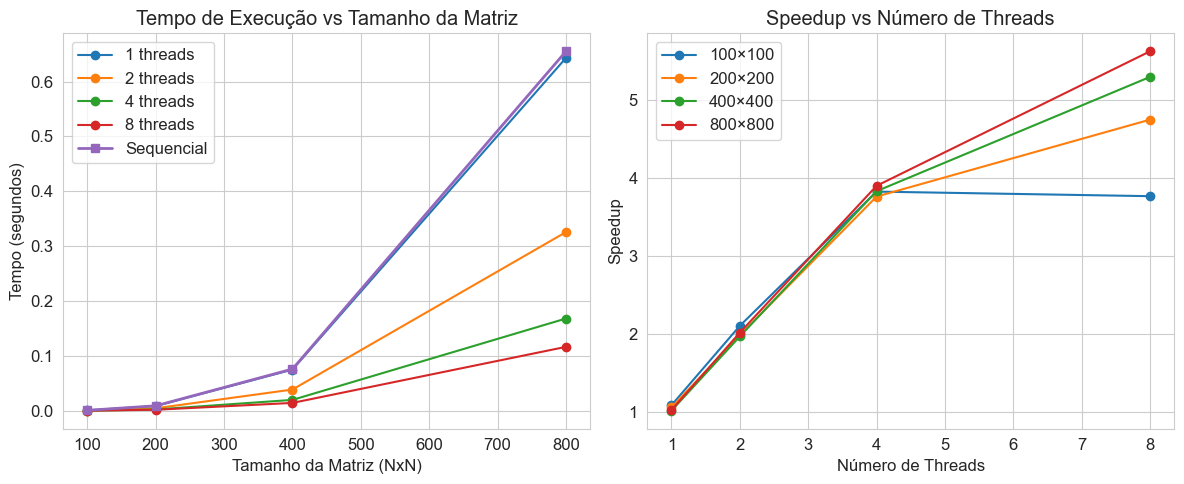


MELHOR PERFORMANCE POR TAMANHO:
    tamanho  threads  tempo_seq  tempo_par  speedup  eficiencia
2       100        4      0.001      0.000    3.822       0.955
7       200        8      0.009      0.002    4.745       0.593
11      400        8      0.076      0.014    5.293       0.662
15      800        8      0.655      0.117    5.621       0.703


In [100]:
if 'dados_completos' in locals():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for thread in threads:
        data = dados_completos[dados_completos['threads'] == thread]
        plt.plot(data['tamanho'], data['tempo_par'], marker='o', label=f'{thread} threads')
    
    plt.plot(seq_data['tamanho'], seq_data['tempo'], marker='s', label='Sequencial', linewidth=2)
    plt.xlabel('Tamanho da Matriz (NxN)')
    plt.ylabel('Tempo (segundos)')
    plt.title('Tempo de Execução vs Tamanho da Matriz')
    plt.legend()
    plt.grid(True)
    
    # Gráfico 2: Speedup por número de threads
    plt.subplot(1, 2, 2)
    for tamanho in tamanhos:
        data = dados_completos[dados_completos['tamanho'] == tamanho]
        plt.plot(data['threads'], data['speedup'], marker='o', label=f'{tamanho}×{tamanho}')
    
    plt.xlabel('Número de Threads')
    plt.ylabel('Speedup')
    plt.title('Speedup vs Número de Threads')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Tabela resumo
    print("\nMELHOR PERFORMANCE POR TAMANHO:")
    print("="*60)
    melhor_por_tamanho = dados_completos.loc[dados_completos.groupby('tamanho')['speedup'].idxmax()]
    print(melhor_por_tamanho[['tamanho', 'threads', 'tempo_seq', 'tempo_par', 'speedup', 'eficiencia']].round(3))
else:
    print("Dados não disponíveis para análise")

# Analise:

### Gráfico 1 - Tempo de Execução vs Tamanho da Matriz:
- **Comportamento exponencial**: O tempo cresce exponencialmente com o tamanho da matriz para todos os casos
- **Convergência das curvas**: Para matrizes pequenas, as diferenças entre sequencial e paralelo são mínimas
- **Divergência significativa**: A partir de 400×400, o algoritmo paralelo mostra vantagem clara sobre o sequencial
- **Escalabilidade**: 8 threads apresenta melhor performance para matrizes grandes (800×800)

### Gráfico 2 - Speedup vs Número de Threads:
- **Ponto ótimo**: 4 threads mostram melhor relação custo-benefício na maioria dos casos
- **Degradação com excesso de Threads**: Em rodada com baixo numero de dados, 8 threads apresentou speedup inferior a 4 threads
- **Dependência do tamanho**: Matrizes maiores aproveitam melhor o paralelismo

### Conclusão:
- A paralelização para baixo numeros de dados nem sempre é vantajosa
- Para grande numeros de dados (800x800) a paralelização se mostrou muito mais eficiente quando adicionada um grande numero de threads